## Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
import sklearn.metrics as skm
import xgboost as xgb

## Load Clean Data

In [2]:
df = pd.read_csv("tsa_claims_clean.csv")

print(len(df))
df.head(2)

145012


/home/perry/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value,Close_Value
0,0909802M,ContinentalAirlines,Property Damage,Checkpoint,Other,Approved,2002-01-04,2002-12-12,EWR,Newark International Airport,350.0,350.0
1,0202417M,-,Property Damage,Checked Baggage,Luggage (all types including footlockers),Settled,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,100.0,50.0


## Feature Engineering

### Make date variables

In [3]:
df["Date_Received"] = pd.to_datetime(df.Date_Received,format="%Y-%m-%d")
df["Month_Received"] = df.Date_Received.dt.month
df["DayMonth_Received"] = df.Date_Received.dt.day
df["DayYear_Received"] = df.Date_Received.dt.dayofyear

df["Incident_Date"] = pd.to_datetime(df.Incident_Date,format="%Y-%m-%d")
df["Incident_Month"] = df.Incident_Date.dt.month
df["Incident_DayMonth"] = df.Incident_Date.dt.day
df["Incident_DayYear"] = df.Incident_Date.dt.dayofyear

df["Report_Delay"] = (df.Date_Received - df.Incident_Date).dt.days

date_var = ["Report_Delay",
        "Month_Received","DayYear_Received","DayMonth_Received",
        "Incident_Month","Incident_DayYear","Incident_DayMonth"]

### Convert text categories to numeric

#### Helper functions

In [4]:
#Dummy vars
#pd.get_dummies(df,prefix=["Type","Site","Airport","Airline"],columns=["Claim_Type","Claim_Site","Airport_Code_Group","Airline_Code_Group"])

#Frequency rank
#Default is max rank + 1
def get_count_rank(var_column):
    val_count = var_column.value_counts(dropna=False)
    conversion_dict = defaultdict(lambda: len(val_count)+1, zip(val_count.index, range(len(val_count.values))))
        
    return conversion_dict
    
#Frequency
#Default is zero
def get_count(var_column):
    val_count = var_column.value_counts(dropna=False)
    conversion_dict = defaultdict(lambda: 0, zip(val_count.index, val_count.values))
    
    return conversion_dict

#Apply conversion from text to numeric
def apply_conversion(var_column, conversion_dict):

    return var_column.map(lambda x: conversion_dict[x])

def create_numeric(train_df, test_df, conversion_func, columns, postfix="_"):
    '''
    Applies conversion function over the training set to train and test sets.
    Inputs:
        train_df: training data (input to conversion func, then applied)
        test_df: test data (conversion applied)
        conversion_func: returns a map assigning numeric value to each text category
        columns: columns to apply
        postfix: postfix to add to created columns (may overwrite, e.g. on empty string)
        
    '''
    maps = {}
    new_columns = []
    
    for name in columns:
        new_name = name+postfix
        new_columns.append(new_name)
        
        maps[name] = conversion_func(train_df[name])
        
        train_df[new_name] = apply_conversion(train_df[name], maps[name])
        test_df[new_name] = apply_conversion(test_df[name],maps[name])

    text_count_var = [x + "_Count" for x in string_categories]
    
    return train_df, test_df, new_columns


#### Conversion 

In [5]:
df, df_holdout = train_test_split(df, test_size = .2, shuffle = True, random_state = 1)

string_categories = ["Claim_Type","Claim_Site","Airport_Code_Group","Airline_Name"]

#Category complaint counts
df, df_holdout, text_count_var = create_numeric(df, df_holdout, get_count, string_categories, "_Count")

#Category complaint rank
df, df_holdout, text_rank_var = create_numeric(df, df_holdout, get_count_rank, string_categories, "_Rank")


print(len(df), len(df_holdout))
df_holdout.head(5)

116009 29003


,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,...,Incident_DayYear,Report_Delay,Claim_Type_Count,Claim_Site_Count,Airport_Code_Group_Count,Airline_Name_Count,Claim_Type_Rank,Claim_Site_Rank,Airport_Code_Group_Rank,Airline_Name_Rank
84038,2006120616757,DeltaAirLines,Passenger Property Loss,Checked Baggage,Computer - Laptop,Denied,2006-11-22,2006-09-23,ORD,Chicago O'Hare International Airport,...,266,60,65645,92115,4178,13948,0,0,4,1
111638,2008071146840,JetBlue,Passenger Property Loss,Checked Baggage,Cosmetics - Perfume; toilet articles; medicine...,Denied,2008-07-07,2008-05-12,JFK,John F. Kennedy International,...,133,56,65645,92115,4601,3861,0,0,2,8
45785,2005020275335,JetBlue,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Denied,2005-01-04,2004-12-09,JFK,John F. Kennedy International,...,344,26,65645,92115,4601,3861,0,0,2,8
93213,2007060726521,AmericanAirlines,Passenger Property Loss,Checkpoint,Cameras - Digital,Denied,2007-06-04,2007-05-07,Other,Other,...,127,28,65645,22714,8251,13709,0,1,0,2
36257,2004110166050,NorthwestAirlines,Property Damage,Checked Baggage,Luggage (all types including footlockers),Denied,2004-08-17,2004-06-19,GEG,Spokane International,...,171,59,44804,92115,519,6854,1,0,56,7


In [9]:
df[["Claim_Site","Claim_Site_Count"]].drop_duplicates()

,Claim_Site,Claim_Site_Count
131458,Checked Baggage,92115
66384,Checkpoint,22714
12536,Other,754
141008,-,207
140627,Motor Vehicle,217
128366,Bus Station,2


## Feature Eval

### Helper fuctions

In [8]:
def print_scores(scores_array, ylabel_strings):
    ''' Prints a table with headings for output of sklearn.metrics.precision_recall_fscore_support
        Inputs: scores_array -> np.array of scores from skm.
                ylabel_strings -> the target labels
    '''
    #Each row is a score in the output, transpose to get features across rows
    array = np.transpose(scores_array) 
    macro_avg = np.average(array,axis=0)
    labels = sorted(ylabel_strings)
    
    max_len = str(np.max([len(s) for s in ylabel_strings]))
        
    print(("\n{:>"+max_len+"} {:>10s} {:>10s} {:>10s} {:>10s}").format("","Precision","Recall","F1","Support"))
    
    for i in range(len(labels)):
        print(("{:>"+max_len+"} {:>10.5f} {:>10.5f} {:>10.5f} {:>10.0f}")
              .format(labels[i],array[i][0],array[i][1],array[i][2],array[i][3]))
    
    print(("{:>"+max_len+"} {:>10.5f} {:>10.5f} {:>10.5f} {:>10.0f}")
          .format("Avg/Tot",macro_avg[0],macro_avg[1],macro_avg[2],macro_avg[3]))
    
#print_scores(np.average(scores,axis=0), Y.unique())

def validation_loop(model,X,Y,k=5,rand_state=1):
    ''' Runs k-fold validation loop for input model, X, Y. Prints classification accuracy 
             and the following per-label metrics: precision, recall, f1, support.
        Inputs: 
                ylabel_strings -> the target labels
    '''
    test_accs, test_scores = [], []
    train_accs, train_scores = [], []
    
    i=1

    for train_ind, test_ind in KFold(k,shuffle=True,random_state=rand_state).split(X,Y):
        print("Starting {} of {} folds".format(i,k))

        model.fit(X[train_ind],Y[train_ind])
        
        #Test metrics
        pred = model.predict(X[test_ind])
        acc = skm.accuracy_score(Y[test_ind],pred)
        test_accs.append(acc)
        score = skm.precision_recall_fscore_support(Y[test_ind],pred)
        test_scores.append(score)
        #print(acc)
        #print(skm.classification_report(Y[test_ind],pred))
        
        #Train metrics
        pred = model.predict(X[train_ind])
        acc = skm.accuracy_score(Y[train_ind],pred)
        train_accs.append(acc)
        score = skm.precision_recall_fscore_support(Y[train_ind],pred)
        train_scores.append(score)
        
        i+=1
    
    print("\nAvg. Train Metrics")
    print ("Accuracy: {:.5f}".format(np.average(train_accs)))
    print_scores(np.average(train_scores,axis=0),np.unique(Y))
    
    print("\nAvg. Validation Metrics")
    print ("Accuracy: {:.5f}".format(np.average(test_accs)))
    print_scores(np.average(test_scores,axis=0),np.unique(Y))
    
    

### Baseline

Baseline accuracy: 
Random Forest: ~50.5% (5 fold cross-test)
Logistic: 46.7%
Naive Bayes: 46.7% (Multinomial), 31.3% (Gaussian)


Random Forest is slightly better than naively guessing the most common class "Denied" (46.7%). It manages to pick up signal on the minority classes (Approved / Settled) so this is much more useful than the naive guess model.

Logistic & Multinomial Naive Bayes are simply guessing the most common class.
Gaussian Naive Bayes guesses "Accepted" for most cases, leading to poor accuracy.

In [9]:
df.Status.value_counts().map(lambda x:[x,round(x/len(df),3)])

Denied      [54144, 0.467]
Approved     [35966, 0.31]
Settled     [25899, 0.223]
Name: Status, dtype: object

#### Random Forest 

In [9]:
features = ["Claim_Value"]
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators=500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)


116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.62740

          Precision     Recall         F1    Support
Approved    0.60787    0.67729    0.64070      28773
  Denied    0.62865    0.77442    0.69396      43315
 Settled    0.70313    0.25073    0.36965      20719
 Avg/Tot    0.64655    0.56748    0.56810      30936

Avg. Validation Metrics
Accuracy: 0.51539

          Precision     Recall         F1    Support
Approved    0.52102    0.57911    0.54852       7193
  Denied    0.54454    0.67116    0.60125      10829
 Settled    0.28202    0.10124    0.14897       5180
 Avg/Tot    0.44920    0.45050    0.43291       7734


#### Logistic Regression

In [10]:
features = ["Claim_Value"]
target = "Status"

model_df=df[[target]+features].dropna()

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = LogisticRegression(C=1000)

validation_loop(model,X,Y,rand_state=1)


Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.46672

          Precision     Recall         F1    Support
Approved    0.00000    0.00000    0.00000      28773
  Denied    0.46672    1.00000    0.63642      43315
 Settled    0.00000    0.00000    0.00000      20719
 Avg/Tot    0.15557    0.33333    0.21214      30936

Avg. Validation Metrics
Accuracy: 0.46672

          Precision     Recall         F1    Support
Approved    0.00000    0.00000    0.00000       7193
  Denied    0.46672    1.00000    0.63641      10829
 Settled    0.00000    0.00000    0.00000       5180
 Avg/Tot    0.15557    0.33333    0.21214       7734


#### Naive Bayes

In [11]:
features = ["Claim_Value"]
target = "Status"

model_df=df[[target]+features].dropna()

X = np.array(model_df[features])
Y = np.array(model_df[target])

print("Multinomial--\n")
model = MultinomialNB()

validation_loop(model,X,Y,rand_state=1)

model = GaussianNB()

print("Gaussian--\n")
validation_loop(model,X,Y,rand_state=1)


Multinomial--

Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.46672

          Precision     Recall         F1    Support
Approved    0.00000    0.00000    0.00000      28773
  Denied    0.46672    1.00000    0.63642      43315
 Settled    0.00000    0.00000    0.00000      20719
 Avg/Tot    0.15557    0.33333    0.21214      30936

Avg. Validation Metrics
Accuracy: 0.46672

          Precision     Recall         F1    Support
Approved    0.00000    0.00000    0.00000       7193
  Denied    0.46672    1.00000    0.63641      10829
 Settled    0.00000    0.00000    0.00000       5180
 Avg/Tot    0.15557    0.33333    0.21214       7734
Gaussian--

Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.31313

          Precision     Recall         F1    Support
Approved    0.31551    0.99694    0.47918      28773
  Denied    0.94625    0.00090  

### Date Features Only

#### Random Forest 

In [32]:
features = ["Claim_Value"]+date_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.80301

          Precision     Recall         F1    Support
Approved    0.80310    0.80722    0.80515      28773
  Denied    0.77992    0.91125    0.84048      43315
 Settled    0.89086    0.57088    0.69584      20719
 Avg/Tot    0.82462    0.76312    0.78049      30936

Avg. Validation Metrics
Accuracy: 0.53027

          Precision     Recall         F1    Support
Approved    0.53323    0.55716    0.54493       7193
  Denied    0.56219    0.69334    0.62091      10829
 Settled    0.33769    0.15195    0.20958       5180
 Avg/Tot    0.47770    0.46748    0.45847       7734


#### Logistic Regression

In [29]:
features = ["Claim_Value"]+date_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = LogisticRegression(C=100)

validation_loop(model,X,Y,rand_state=1)


116009
116009
Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.46750

          Precision     Recall         F1    Support
Approved    0.12431    0.00550    0.01053      28773
  Denied    0.46709    0.99802    0.63635      43315
 Settled    0.08571    0.00003    0.00006      20719
 Avg/Tot    0.22571    0.33452    0.21565      30936

Avg. Validation Metrics
Accuracy: 0.46771

          Precision     Recall         F1    Support
Approved    0.12775    0.00611    0.01165       7193
  Denied    0.46719    0.99801    0.63644      10829
 Settled    0.00000    0.00000    0.00000       5180
 Avg/Tot    0.19831    0.33471    0.21603       7734


### Categorical Features Only

In [40]:
model_df = pd.get_dummies(df,prefix=["Type","Site","Airport","Airline"],columns=["Claim_Type","Claim_Site","Airport_Code_Group","Airline_Name"])
model_df

,Claim_Number,Item,Status,Date_Received,Incident_Date,Airport_Name_Group,Claim_Value,Close_Value,Month_Received,DayMonth_Received,...,Airline_VirginExpress,Airline_VisionAirlines,Airline_VolarisAirlines,Airline_Webjet,Airline_WesternPacificAirlinesIncWestpac,Airline_WestjetAirlinesLtd,Airline_WigginsAirways,Airline_XLAirways,Airline_XtraAirways,Airline_vivaAerobus
131458,2010082075174,Cosmetics & Grooming,Approved,2010-08-16,2010-07-26,John Wayne,35.00,NaN,8,16,...,0,0,0,0,0,0,0,0,0,0
48831,2005031177670,Luggage (all types including footlockers),Denied,2005-02-08,2004-09-09,Sacramento International Airport,43.09,0.00,2,8,...,0,0,0,0,0,0,0,0,0,0
126130,2009082462923,Clothing - Shoes; belts; accessories; etc.,Settled,2009-08-21,2009-07-28,San Diego International,1618.34,809.17,8,21,...,0,0,0,0,0,0,0,0,0,0
24131,0226165M,Cameras - Digital,Approved,2004-02-26,2003-12-25,General Mitchell International Airport,155.76,155.76,2,26,...,0,0,0,0,0,0,0,0,0,0
114314,2008091049732,Jewelry - Fine,Denied,2008-09-08,2008-07-31,Bradley International Airport,717.00,0.00,9,8,...,0,0,0,0,0,0,0,0,0,0
120796,2009040157077,Locks; Luggage (all types including footlockers),Denied,2009-03-12,2009-02-22,San Diego International,750.00,0.00,3,12,...,0,0,0,0,0,0,0,0,0,0
134368,2011071185085,Other,Approved,2011-06-28,2011-04-08,Hartsfield-Jackson Atlanta International Airport,180.39,NaN,6,28,...,0,0,0,0,0,0,0,0,0,0
137529,2012052794318,Clothing,Approved,2012-05-07,2012-02-23,Chicago O'Hare International Airport,76.67,NaN,5,7,...,0,0,0,0,0,0,0,0,0,0
59141,2005071488868,Other,Denied,2005-07-13,2005-06-23,Honolulu International Airport,600.00,0.00,7,13,...,0,0,0,0,0,0,0,0,0,0
12875,0916079M,Other,Settled,2003-09-16,2003-08-23,Boston (Logan) International Airport,600.00,336.00,9,16,...,0,0,0,0,0,0,0,0,0,0


#### Dummy Vars (RF)

In [48]:
dummies_df = pd.get_dummies(df[["Claim_Type","Claim_Site","Airport_Code_Group","Airline_Name"]],prefix=["Type","Site","Airport","Airline"])

features = ["Claim_Value"] + list(dummies_df.columns)
target = "Status"

model_df=df[["Status","Claim_Value"]].join(dummies_df).dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.77514

          Precision     Recall         F1    Support
Approved    0.77333    0.79362    0.78334      28773
  Denied    0.77236    0.86746    0.81715      43315
 Settled    0.78808    0.55649    0.65234      20719
 Avg/Tot    0.77792    0.73919    0.75094      30936

Avg. Validation Metrics
Accuracy: 0.53664

          Precision     Recall         F1    Support
Approved    0.54110    0.56160    0.55115       7193
  Denied    0.58285    0.66964    0.62323      10829
 Settled    0.35221    0.22393    0.27372       5180
 Avg/Tot    0.49205    0.48506    0.48270       7734


[('Claim_Value', 0.56499800023981106),
 ('Type_-', 0.0053973543154224347),
 ('Type_Bus Terminal', 9.1820409239043591e-06),
 ('Type_Complaint', 1.1709718483042978e-05),
 ('Type_Employee Loss (MPCECA)', 0.0010121833127357508),
 ('Type_Motor Vehicle', 0.00059969940176703206),
 ('Type_Passenger Property Loss', 0.015047860439684256),
 ('Type_Passenger Theft', 0.00099714854549721598),
 ('Type_Personal Injury', 0.0013866843992652673),
 ('Type_Property Damage', 0.013650088400602896),
 ('Site_-', 0.00077185915125844063),
 ('Site_Bus Station', 1.8710449950119036e-05),
 ('Site_Checked Baggage', 0.014468192572688835),
 ('Site_Checkpoint', 0.01492466009687823),
 ('Site_Motor Vehicle', 0.00085266880214057131),
 ('Site_Other', 0.0016138748137870778),
 ('Airport_-', 0.0048345994397376909),
 ('Airport_ABQ', 0.0024887441044025146),
 ('Airport_ALB', 0.0025382776861847685),
 ('Airport_ANC', 0.0022129048628708623),
 ('Airport_ATL', 0.0037547585874768458),
 ('Airport_AUS', 0.002283508254552368),
 ('Airport_

#### Count (RF + Log Regression)

In [49]:
features = ["Claim_Value"] + text_count_var 
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.79756

          Precision     Recall         F1    Support
Approved    0.79547    0.81453    0.80488      28773
  Denied    0.78693    0.89129    0.83586      43315
 Settled    0.83836    0.57804    0.68427      20719
 Avg/Tot    0.80692    0.76128    0.77501      30936

Avg. Validation Metrics
Accuracy: 0.54247

          Precision     Recall         F1    Support
Approved    0.54760    0.57390    0.56044       7193
  Denied    0.58205    0.68297    0.62847      10829
 Settled    0.35942    0.20503    0.26105       5180
 Avg/Tot    0.49635    0.48730    0.48332       7734


[('Claim_Value', 0.57899627893763228),
 ('Claim_Type_Count', 0.03887884528896713),
 ('Claim_Site_Count', 0.032980005149294368),
 ('Airport_Code_Group_Count', 0.23453280014718467),
 ('Airline_Name_Count', 0.11461207047692139)]

In [55]:
features = ["Claim_Value"] + text_count_var 
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = LogisticRegression(C=100)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
print(model_df.columns[1:])
print(model.coef_)
print(model.intercept_)

116009
116009
Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.47509

          Precision     Recall         F1    Support
Approved    0.39088    0.06265    0.08349      28773
  Denied    0.47576    0.97304    0.63801      43315
 Settled    0.06979    0.00705    0.01281      20719
 Avg/Tot    0.31214    0.34758    0.24477      30936

Avg. Validation Metrics
Accuracy: 0.47507

          Precision     Recall         F1    Support
Approved    0.38953    0.06159    0.08299       7193
  Denied    0.47517    0.97305    0.63763      10829
 Settled    0.07432    0.00734    0.01336       5180
 Avg/Tot    0.31300    0.34733    0.24466       7734
Index(['Claim_Value', 'Claim_Type_Count', 'Claim_Site_Count',
       'Airport_Code_Group_Count', 'Airline_Name_Count'],
      dtype='object')
[[ -1.81380975e-06  -3.57675834e-06  -8.71827051e-06  -8.65997104e-07
    5.69407640e-06]
 [  2.63542199e-06  -7.69016569e-07   3.82046726e-07  -3.83432305e-

#### Rank (RF)

In [50]:
features = ["Claim_Value"] + text_rank_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.79775

          Precision     Recall         F1    Support
Approved    0.79495    0.81509    0.80489      28773
  Denied    0.78770    0.89092    0.83613      43315
 Settled    0.83796    0.57890    0.68474      20719
 Avg/Tot    0.80687    0.76163    0.77526      30936

Avg. Validation Metrics
Accuracy: 0.54229

          Precision     Recall         F1    Support
Approved    0.54773    0.57440    0.56075       7193
  Denied    0.58231    0.68220    0.62830      10829
 Settled    0.35768    0.20516    0.26070       5180
 Avg/Tot    0.49591    0.48725    0.48325       7734


[('Claim_Value', 0.57931198456233213),
 ('Claim_Type_Rank', 0.038769060637099034),
 ('Claim_Site_Rank', 0.032256160298941891),
 ('Airport_Code_Group_Rank', 0.2352106500135796),
 ('Airline_Name_Rank', 0.1144521444880468)]

#### Count + Rank (RF)

In [51]:
features = ["Claim_Value"] + text_count_var + text_rank_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.78172

          Precision     Recall         F1    Support
Approved    0.77927    0.80042    0.78970      28773
  Denied    0.77573    0.87832    0.82385      43315
 Settled    0.80751    0.55380    0.65701      20719
 Avg/Tot    0.78750    0.74418    0.75685      30936

Avg. Validation Metrics
Accuracy: 0.54075

          Precision     Recall         F1    Support
Approved    0.54663    0.56949    0.55782       7193
  Denied    0.58234    0.67740    0.62627      10829
 Settled    0.35838    0.21516    0.26881       5180
 Avg/Tot    0.49578    0.48735    0.48430       7734


[('Claim_Value', 0.57308535860763909),
 ('Claim_Type_Count', 0.019068273269621568),
 ('Claim_Site_Count', 0.014709245138788881),
 ('Airport_Code_Group_Count', 0.11996055457156614),
 ('Airline_Name_Count', 0.058548379862036738),
 ('Claim_Type_Rank', 0.01961183474382688),
 ('Claim_Site_Rank', 0.015475524120057097),
 ('Airport_Code_Group_Rank', 0.12055615935083604),
 ('Airline_Name_Rank', 0.058984670335627334)]

### Date + Categorical Features

#### Random Forest

In [12]:
features = ["Claim_Value"]+date_var+text_count_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 500, min_samples_split=10, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.90145

          Precision     Recall         F1    Support
Approved    0.90052    0.90050    0.90051      28773
  Denied    0.87754    0.96811    0.92060      43315
 Settled    0.97340    0.76340    0.85570      20719
 Avg/Tot    0.91715    0.87734    0.89227      30936

Avg. Validation Metrics
Accuracy: 0.56534

          Precision     Recall         F1    Support
Approved    0.56398    0.61476    0.58827       7193
  Denied    0.58986    0.72694    0.65126      10829
 Settled    0.40842    0.15889    0.22876       5180
 Avg/Tot    0.52075    0.50019    0.48943       7734


[('Claim_Value', 0.31085184848564673),
 ('Report_Delay', 0.12111376890634136),
 ('Month_Received', 0.016582964200315194),
 ('DayYear_Received', 0.08012282508471183),
 ('DayMonth_Received', 0.06299128134427572),
 ('Incident_Month', 0.01648979623348674),
 ('Incident_DayYear', 0.08025678658135556),
 ('Incident_DayMonth', 0.06310572326248895),
 ('Claim_Type_Count', 0.03435789907403577),
 ('Claim_Site_Count', 0.028464495373235994),
 ('Airport_Code_Group_Count', 0.11068199505464085),
 ('Airline_Name_Count', 0.07498061639946524)]

### Export Features CSV

In [55]:
features = ["Claim_Value"]+date_var+text_count_var
target = "Status"
csv_df=df[[target]+features].dropna()

csv_df.to_csv("tsa_model_features.csv",index=False)

## Model Eval

In [11]:
%%html
<style>
table {float:left}
</style>

|Algo (5x Val) | Accuracy | Accept F1 | Deny F1 | Settle F1 | Avg F1
|--- | --- | --- | --- | --- | ---
|Random Forest | 56.4 | 58.6 | 65.1 | 23.3 | 49.0
|XGBoost | 57.6 | 60.3 | 66.1 | 21.1 | 49.2
|Logistic Regression | 47.5 | . | . | . | . 
|Gaussian NB | 31.3 | . | . | . | . 

**Random Forest**  

|Class   | Precision   |Recall    |F1        |Support  
|--------|----------|----------|----------|----------
|Approved|   0.56240|   0.61233|   0.58630|      7193  
|  Denied|   0.59069|   0.72446|   0.65077|     10829  
| Settled|   0.40515|   0.16331|   0.23278|      5180  
| Avg/Tot|   0.51941|   0.50004|   0.48995|      7734  

**XGBoost**  

|Class   | Precision|    Recall|        F1|   Support
|--------|----------|----------|----------|----------
|Approved|   0.56879|   0.64239|   0.60335|      7193  
|  Denied|   0.59696|   0.74112|   0.66127|     10829  
| Settled|   0.43994|   0.13873|   0.21086|      5180  
| Avg/Tot|   0.53523|   0.50742|   0.49183|      7734  

### Random Forest

In [8]:
features = ["Claim_Value"]+date_var+text_count_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = RandomForestClassifier(n_estimators = 1000, min_samples_split=8, n_jobs=-1)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
list(zip(model_df.columns[1:],model.feature_importances_))

116009
116009
Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.93867

          Precision     Recall         F1    Support
Approved    0.93702    0.93439    0.93570      28773
  Denied    0.92088    0.98251    0.95070      43315
 Settled    0.98724    0.85295    0.91519      20719
 Avg/Tot    0.94838    0.92329    0.93387      30936

Avg. Validation Metrics
Accuracy: 0.56443

          Precision     Recall         F1    Support
Approved    0.56240    0.61233    0.58630       7193
  Denied    0.59069    0.72446    0.65077      10829
 Settled    0.40515    0.16331    0.23278       5180
 Avg/Tot    0.51941    0.50004    0.48995       7734


[('Claim_Value', 0.298025592376617),
 ('Report_Delay', 0.12492822486478018),
 ('Month_Received', 0.017249924280268395),
 ('DayYear_Received', 0.08138587615250226),
 ('DayMonth_Received', 0.06510331919533258),
 ('Incident_Month', 0.017273763176359733),
 ('Incident_DayYear', 0.0814084247911109),
 ('Incident_DayMonth', 0.06512275702476293),
 ('Claim_Type_Count', 0.03233922274850984),
 ('Claim_Site_Count', 0.02617946731107325),
 ('Airport_Code_Group_Count', 0.11426545178410914),
 ('Airline_Name_Count', 0.07671797629457323)]

In [9]:
model_df_holdout = df_holdout[[target]+features].dropna()
X_holdout = np.array(model_df_holdout[features])
Y_holdout = np.array(model_df_holdout[target])
print(len(model_df_holdout))

model.fit(X,Y)

print("Training")
pred = model.predict(X)
print(skm.accuracy_score(Y,pred))
print(skm.classification_report(Y, pred))

print("\nHoldout")
pred = model.predict(X_holdout)
print(skm.accuracy_score(Y_holdout,pred))
print(skm.classification_report(Y_holdout, pred))

list(zip(model_df.columns[1:],model.feature_importances_))

29003
Training
0.9367462869260144
             precision    recall  f1-score   support

   Approved       0.93      0.93      0.93     35966
     Denied       0.92      0.98      0.95     54144
    Settled       0.99      0.85      0.91     25899

avg / total       0.94      0.94      0.94    116009


Holdout
0.5651484329207324
             precision    recall  f1-score   support

   Approved       0.57      0.61      0.59      9055
     Denied       0.59      0.72      0.65     13562
    Settled       0.40      0.17      0.24      6386

avg / total       0.54      0.57      0.54     29003



[('Claim_Value', 0.2977001657215341),
 ('Report_Delay', 0.12488615094597737),
 ('Month_Received', 0.01735733497994191),
 ('DayYear_Received', 0.08149810471555213),
 ('DayMonth_Received', 0.06514515431352054),
 ('Incident_Month', 0.01742991654426116),
 ('Incident_DayYear', 0.08154258718812088),
 ('Incident_DayMonth', 0.06501928590675507),
 ('Claim_Type_Count', 0.032470987304252984),
 ('Claim_Site_Count', 0.02611842542565047),
 ('Airport_Code_Group_Count', 0.11394158128189376),
 ('Airline_Name_Count', 0.07689030567254002)]

### XGBoost

In [13]:
features = ["Claim_Value"]+date_var+text_count_var
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = model_df[features].reset_index(drop=True)
Y = model_df[target].reset_index(drop=True)

model = xgb.XGBClassifier(n_estimators = 30000,
                          learning_rate = .2,
                          max_depth = 4,
                          objective = "multi:softmax",
                          subsample=1,
                          min_child_weight=1,
                          colsample_bytree=.8,
                          random_state = 1,
                          n_jobs = -1
                         )

test_accs, test_scores = [], []
train_accs, train_scores = [], []

logloss = []
ntrees = []

i=1
k=5
rand_state = 1

for train_ind, test_ind in KFold(k,shuffle=True,random_state=rand_state).split(X,Y):
    print("Starting {} of {} folds".format(i,k))

    eval_set=[(X.iloc[train_ind],Y.iloc[train_ind]),(X.iloc[test_ind],Y.iloc[test_ind])] 
    fit_model = model.fit( 
                    X.iloc[train_ind], Y.iloc[train_ind], 
                    eval_set=eval_set,
                    eval_metric='mlogloss',
                    early_stopping_rounds=50,
                    verbose=False
                   )
    
    logloss.append(model.best_score)
    ntrees.append(model.best_ntree_limit)
    
    #Test metrics
    pred = model.predict(X.iloc[test_ind],ntree_limit=model.best_ntree_limit)
    acc = skm.accuracy_score(Y.iloc[test_ind],pred)
    test_accs.append(acc)
    score = skm.precision_recall_fscore_support(Y.iloc[test_ind],pred)
    test_scores.append(score)
    #print(acc)
    #print(skm.classification_report(Y[test_ind],pred))

    #Train metrics
    pred = model.predict(X.iloc[train_ind],ntree_limit=model.best_ntree_limit)
    acc = skm.accuracy_score(Y.iloc[train_ind],pred)
    train_accs.append(acc)
    score = skm.precision_recall_fscore_support(Y.iloc[train_ind],pred)
    train_scores.append(score)

    i+=1

print("\nAvg. Train Metrics")
print ("Accuracy: {:.5f}".format(np.average(train_accs)))
print_scores(np.average(train_scores,axis=0),np.unique(Y))

print("\nAvg. Validation Metrics")
print ("Accuracy: {:.5f}".format(np.average(test_accs)))
print_scores(np.average(test_scores,axis=0),np.unique(Y))

print("\nLogloss:", np.average(logloss), "Std Dev:", np.std(logloss))
print("Best number of trees", ntrees)

116009
116009
Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 2 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 3 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 4 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 5 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Avg. Train Metrics
Accuracy: 0.60152

          Precision     Recall         F1    Support
Approved    0.59389    0.67204    0.63055      28773
  Denied    0.61479    0.76209    0.68056      43315
 Settled    0.53059    0.16793    0.25499      20719
 Avg/Tot    0.57975    0.53402    0.52203      30936

Avg. Validation Metrics
Accuracy: 0.57581

          Precision     Recall         F1    Support
Approved    0.56893    0.64395    0.60412       7193
  Denied    0.59599    0.74178    0.66094      10829
 Settled    0.43938    0.13410    0.20538       5180
 Avg/Tot    0.53477    0.50661    0.49015       7734

Logloss: 0.8905422 Std Dev: 0.00575205776744288
Best number of trees [273, 267, 275, 393, 328]


In [14]:
# Not sure about this part
model_df_holdout = df_holdout[[target]+features].dropna()
X_holdout = model_df_holdout[features]
Y_holdout = model_df_holdout[target]
print(len(model_df_holdout))

model = xgb.XGBClassifier(n_estimators = int(np.average(ntrees)),
                          learning_rate = .2,
                          max_depth = 4,
                          objective = "multi:softmax",
                          subsample=1,
                          min_child_weight=1,
                          colsample_bytree=.8,
                          random_state = 1,
                          n_jobs = -1
                         )

fit_model = model.fit(X, Y)

print("Training")
pred = model.predict(X)
print(skm.accuracy_score(Y,pred))
print(skm.classification_report(Y, pred))

print("\nHoldout")
pred = model.predict(X_holdout)
print(skm.accuracy_score(Y_holdout,pred))
print(skm.classification_report(Y_holdout, pred))

list(zip(model_df.columns[1:],fit_model.feature_importances_))

29003
Training


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5976605263384738
             precision    recall  f1-score   support

   Approved       0.59      0.67      0.63     35966
     Denied       0.61      0.76      0.68     54144
    Settled       0.52      0.16      0.25     25899

avg / total       0.58      0.60      0.57    116009


Holdout


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5759059407647484
             precision    recall  f1-score   support

   Approved       0.57      0.64      0.60      9055
     Denied       0.60      0.74      0.66     13562
    Settled       0.43      0.14      0.21      6386

avg / total       0.55      0.58      0.54     29003



[('Claim_Value', 0.23678161),
 ('Report_Delay', 0.15370591),
 ('Month_Received', 0.013476021),
 ('DayYear_Received', 0.14704716),
 ('DayMonth_Received', 0.0660325),
 ('Incident_Month', 0.0007927071),
 ('Incident_DayYear', 0.038446292),
 ('Incident_DayMonth', 0.014823623),
 ('Claim_Type_Count', 0.054458976),
 ('Claim_Site_Count', 0.04375743),
 ('Airport_Code_Group_Count', 0.12944907),
 ('Airline_Name_Count', 0.1012287)]

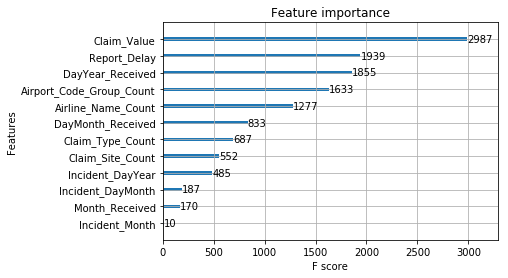

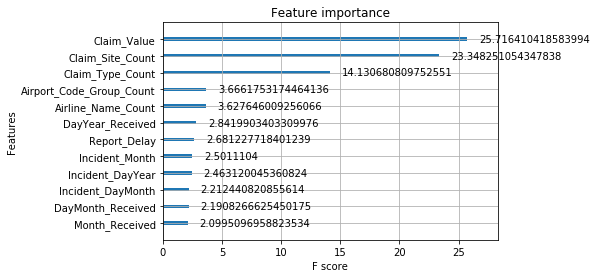

In [18]:
xgb.plot_importance(fit_model)

xgb.plot_importance(fit_model, importance_type="gain")


### Logistic Regression

In [14]:
features = ["Claim_Value"]+date_var+text_count_var 
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = LogisticRegression(C=100)

validation_loop(model,X,Y,rand_state=1)

model.fit(X,Y)
print(model_df.columns[1:])
print(model.coef_)
print(model.intercept_)

116009
116009
Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.47521

          Precision     Recall         F1    Support
Approved    0.39128    0.06362    0.08439      28773
  Denied    0.47564    0.97330    0.63799      43315
 Settled    0.06965    0.00571    0.01056      20719
 Avg/Tot    0.31219    0.34754    0.24431      30936

Avg. Validation Metrics
Accuracy: 0.47519

          Precision     Recall         F1    Support
Approved    0.38980    0.06292    0.08417       7193
  Denied    0.47510    0.97313    0.63760      10829
 Settled    0.07409    0.00588    0.01090       5180
 Avg/Tot    0.31300    0.34731    0.24422       7734
Index(['Claim_Value', 'Report_Delay', 'Month_Received', 'DayYear_Received',
       'DayMonth_Received', 'Incident_Month', 'Incident_DayYear',
       'Incident_DayMonth', 'Claim_Type_Count', 'Claim_Site_Count',
       'Airport_Code_Group_Count', 'Airline_Name_Count'],
      dtype='object')
[[-1.8138

### Naive Bayes

In [15]:
features = ["Claim_Value"]+date_var+text_count_var 
target = "Status"

model_df=df[[target]+features].dropna()
print(len(df))
print(len(model_df))

X = np.array(model_df[features])
Y = np.array(model_df[target])

model = GaussianNB()

validation_loop(model,X,Y,rand_state=1)

116009
116009
Starting 1 of 5 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Avg. Train Metrics
Accuracy: 0.31318

          Precision     Recall         F1    Support
Approved    0.31556    0.99716    0.47927      28773
  Denied    0.94610    0.00092    0.00184      43315
 Settled    0.03882    0.01616    0.02282      20719
 Avg/Tot    0.43349    0.33808    0.16798      30936

Avg. Validation Metrics
Accuracy: 0.31298

          Precision     Recall         F1    Support
Approved    0.31566    0.99732    0.47938       7193
  Denied    0.97500    0.00078    0.00155      10829
 Settled    0.03673    0.01530    0.02160       5180
 Avg/Tot    0.44247    0.33780    0.16751       7734


## Model Tuning (XGBoost)

### Helper Function

In [37]:
def xgb_val_loop(model,X,Y,k=4,rand_state=1):
    ''' Runs k-fold validation loop for input model, X, Y. Prints classification accuracy 
             and the following per-label metrics: precision, recall, f1, support.
        Inputs: 
                ylabel_strings -> the target labels
    '''
    test_accs, test_scores = [], []
    #train_accs, train_scores = [], []
    logloss = []
    ntrees = []

    for train_ind, test_ind in KFold(k,shuffle=True,random_state=rand_state).split(X,Y):
        eval_set=[(X.iloc[train_ind],Y.iloc[train_ind]),(X.iloc[test_ind],Y.iloc[test_ind])] #tracking train/validation error as we go
        fit_model = model.fit( 
                        X.iloc[train_ind], Y.iloc[train_ind], 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=50,
                        verbose=False
                       )

        logloss.append(model.best_score)
        ntrees.append(model.best_ntree_limit)

        #Test metrics
        pred = model.predict(X.iloc[test_ind],ntree_limit=model.best_ntree_limit)
        acc = skm.accuracy_score(Y.iloc[test_ind],pred)
        test_accs.append(acc)
        score = skm.precision_recall_fscore_support(Y.iloc[test_ind],pred)
        test_scores.append(score)
        #print(acc)
        #print(skm.classification_report(Y[test_ind],pred))

        #Train metrics
        #pred = model.predict(X.iloc[train_ind],ntree_limit=model.best_ntree_limit)
        #acc = skm.accuracy_score(Y.iloc[train_ind],pred)
        #train_accs.append(acc)
        #score = skm.precision_recall_fscore_support(Y.iloc[train_ind],pred)
        #train_scores.append(score)
    
    return {"logloss":np.average(logloss),
            "ntrees":np.average(ntrees),
            "test_acc":np.average(test_accs),
            "test_scores":np.average(test_scores,axis=0)}
            


### Grid Search

In [38]:
features = ["Claim_Value"]+date_var+text_count_var
target = "Status"

model_df=df[[target]+features].dropna()
X = model_df[features].reset_index(drop=True)
Y = model_df[target].reset_index(drop=True)

max_depths = [3,6,9]
subsamples = [.6,.8,1]
min_child_weights = [1,3,5]
colsample_bytrees = [.6,.8,1]

i = 1

result = dict()

for md in max_depths:
    for s in subsamples:
        for mcw in min_child_weights:
            for csbt in colsample_bytrees:
                model =  xgb.XGBClassifier(max_depth = md,
                                           subsamples = s,
                                           min_child_weight=mcw,
                                           colsample_bytree=csbt,
                                           n_estimators=30000,
                                           learning_rate=.1,
                                           objective = "multi:softmax",
                                           random_state = 1,
                                           n_jobs = -1)
                print("XVal on tree {} with params: {:3d} | {:3.1f} | {:3d} | {:3.1f}"
                      .format(i,md,s,mcw,csbt))
                
                print(datetime.now().time())
                
                result[(md,s,mcw,csbt)] = xgb_val_loop(model,X,Y,rand_state=1)
                
                with open("grid_dict.pickle","wb") as f:
                    pickle.dump(result, f)
                
                i+=1
                

                

XVal on tree 1 with params:   3 | 0.6 |   1 | 0.6
02:59:15.280998


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 2 with params:   3 | 0.6 |   1 | 0.8
03:02:16.766111


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 3 with params:   3 | 0.6 |   1 | 1.0
03:05:35.591360


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 4 with params:   3 | 0.6 |   3 | 0.6
03:09:17.854103


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 5 with params:   3 | 0.6 |   3 | 0.8
03:12:06.061554


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 6 with params:   3 | 0.6 |   3 | 1.0
03:15:36.311561


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 7 with params:   3 | 0.6 |   5 | 0.6
03:19:10.783425


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 8 with params:   3 | 0.6 |   5 | 0.8
03:22:05.081672


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 9 with params:   3 | 0.6 |   5 | 1.0
03:25:39.149469


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 10 with params:   3 | 0.8 |   1 | 0.6
03:29:27.094664


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 11 with params:   3 | 0.8 |   1 | 0.8
03:32:30.660997


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 12 with params:   3 | 0.8 |   1 | 1.0
03:35:50.366397


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 13 with params:   3 | 0.8 |   3 | 0.6
03:39:33.780594


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 14 with params:   3 | 0.8 |   3 | 0.8
03:42:28.625464


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 15 with params:   3 | 0.8 |   3 | 1.0
03:46:03.190417


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 16 with params:   3 | 0.8 |   5 | 0.6
03:49:41.017114


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 17 with params:   3 | 0.8 |   5 | 0.8
03:52:34.464202


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 18 with params:   3 | 0.8 |   5 | 1.0
03:56:02.002064


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 19 with params:   3 | 1.0 |   1 | 0.6
03:59:50.315832


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 20 with params:   3 | 1.0 |   1 | 0.8
04:02:53.567831


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 21 with params:   3 | 1.0 |   1 | 1.0
04:06:15.832451


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 22 with params:   3 | 1.0 |   3 | 0.6
04:09:56.494498


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 23 with params:   3 | 1.0 |   3 | 0.8
04:12:43.780511


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 24 with params:   3 | 1.0 |   3 | 1.0
04:16:14.415716


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 25 with params:   3 | 1.0 |   5 | 0.6
04:19:49.228227


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 26 with params:   3 | 1.0 |   5 | 0.8
04:22:42.666803


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 27 with params:   3 | 1.0 |   5 | 1.0
04:26:09.222540


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 28 with params:   6 | 0.6 |   1 | 0.6
04:29:55.763712


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 29 with params:   6 | 0.6 |   1 | 0.8
04:31:42.093537


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 30 with params:   6 | 0.6 |   1 | 1.0
04:33:23.415107


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 31 with params:   6 | 0.6 |   3 | 0.6
04:35:16.441339


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 32 with params:   6 | 0.6 |   3 | 0.8
04:36:53.912503


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 33 with params:   6 | 0.6 |   3 | 1.0
04:38:50.460654


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 34 with params:   6 | 0.6 |   5 | 0.6
04:40:41.414261


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 35 with params:   6 | 0.6 |   5 | 0.8
04:42:38.432265


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 36 with params:   6 | 0.6 |   5 | 1.0
04:44:23.036044


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 37 with params:   6 | 0.8 |   1 | 0.6
04:46:09.904654


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 38 with params:   6 | 0.8 |   1 | 0.8
04:47:57.016185


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 39 with params:   6 | 0.8 |   1 | 1.0
04:49:37.628198


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 40 with params:   6 | 0.8 |   3 | 0.6
04:51:31.195302


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 41 with params:   6 | 0.8 |   3 | 0.8
04:53:09.320041


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 42 with params:   6 | 0.8 |   3 | 1.0
04:55:04.948045


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 43 with params:   6 | 0.8 |   5 | 0.6
04:56:55.496084


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 44 with params:   6 | 0.8 |   5 | 0.8
04:58:53.671973


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 45 with params:   6 | 0.8 |   5 | 1.0
05:00:37.106283


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 46 with params:   6 | 1.0 |   1 | 0.6
05:02:24.831306


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 47 with params:   6 | 1.0 |   1 | 0.8
05:04:12.491784


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 48 with params:   6 | 1.0 |   1 | 1.0
05:05:53.825572


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 49 with params:   6 | 1.0 |   3 | 0.6
05:07:46.928281


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 50 with params:   6 | 1.0 |   3 | 0.8
05:09:23.992600


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 51 with params:   6 | 1.0 |   3 | 1.0
05:11:19.793553


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 52 with params:   6 | 1.0 |   5 | 0.6
05:13:10.292285


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 53 with params:   6 | 1.0 |   5 | 0.8
05:15:07.071129


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 54 with params:   6 | 1.0 |   5 | 1.0
05:16:51.542385


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 55 with params:   9 | 0.6 |   1 | 0.6
05:18:40.262497


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 56 with params:   9 | 0.6 |   1 | 0.8
05:19:57.554238


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 57 with params:   9 | 0.6 |   1 | 1.0
05:21:25.243665


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 58 with params:   9 | 0.6 |   3 | 0.6
05:22:53.907907


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 59 with params:   9 | 0.6 |   3 | 0.8
05:24:15.524658


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 60 with params:   9 | 0.6 |   3 | 1.0
05:25:41.393614


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 61 with params:   9 | 0.6 |   5 | 0.6
05:27:13.974625


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 62 with params:   9 | 0.6 |   5 | 0.8
05:28:42.161898


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 63 with params:   9 | 0.6 |   5 | 1.0
05:30:03.771169


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 64 with params:   9 | 0.8 |   1 | 0.6
05:31:37.936294


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 65 with params:   9 | 0.8 |   1 | 0.8
05:32:55.587749


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 66 with params:   9 | 0.8 |   1 | 1.0
05:34:23.718167


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 67 with params:   9 | 0.8 |   3 | 0.6
05:35:52.801571


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 68 with params:   9 | 0.8 |   3 | 0.8
05:37:14.211469


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 69 with params:   9 | 0.8 |   3 | 1.0
05:38:39.064328


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 70 with params:   9 | 0.8 |   5 | 0.6
05:40:11.866851


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 71 with params:   9 | 0.8 |   5 | 0.8
05:41:39.831021


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 72 with params:   9 | 0.8 |   5 | 1.0
05:43:01.709795


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 73 with params:   9 | 1.0 |   1 | 0.6
05:44:35.745583


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 74 with params:   9 | 1.0 |   1 | 0.8
05:45:53.036153


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 75 with params:   9 | 1.0 |   1 | 1.0
05:47:21.014356


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 76 with params:   9 | 1.0 |   3 | 0.6
05:48:49.643388


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 77 with params:   9 | 1.0 |   3 | 0.8
05:50:11.024627


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 78 with params:   9 | 1.0 |   3 | 1.0
05:51:36.282620


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 79 with params:   9 | 1.0 |   5 | 0.6
05:53:09.382423


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 80 with params:   9 | 1.0 |   5 | 0.8
05:54:37.636340


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

XVal on tree 81 with params:   9 | 1.0 |   5 | 1.0
05:56:00.082601


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

In [58]:
grid_result = {}

with open("grid_dict.pickle","rb") as f:
    grid_result = pickle.load(f)       

best_score = 0
best_params = None
accuracy_dict = {}
    
for key in grid_result.keys():
    score = grid_result[key]["test_acc"]
    if score > best_score:
        best_score = score
        best_params = key
    accuracy_dict[score]=key

ranked_params = [accuracy_dict[x] for x in sorted(accuracy_dict.keys())]
    
best_result = grid_result[best_params]

print(best_params)
print("Best Accuracy",best_result["test_acc"])
print("Best logloss",best_result["logloss"])
print("Best Tree Depth",best_result["ntrees"])
print_scores(best_result["test_scores"],np.unique(Y))



(6, 0.6, 5, 0.6)
Best Accuracy 0.5762742164458621
Best logloss 0.8900632500000001
Best Tree Depth 319.0

          Precision     Recall         F1    Support
Approved    0.56927    0.64301    0.60389       8992
  Denied    0.59771    0.74094    0.66166      13536
 Settled    0.43664    0.13935    0.21123       6475
 Avg/Tot    0.53454    0.50776    0.49226       9667


In [67]:
#print(top_list[-1])

#print(grid_result[(6, 0.6, 5, 0.6)])

#print(grid_result[(6, 1, 5, 0.6)])

#print([(x) for x in zip(grid_result.keys(),grid_result.values()) if x[1]["test_acc"]>=0.5762742164458621])

[(p,grid_result[p]) for p in ranked_params[-3:]]

### Final Model

In [72]:
model_df_holdout = df_holdout[[target]+features].dropna()
X_holdout = model_df_holdout[features]
Y_holdout = model_df_holdout[target]
print(len(model_df_holdout))

#Model using params from grid search
model =  xgb.XGBClassifier(max_depth = 6,
                           subsamples = 1,
                           min_child_weight=6,
                           colsample_bytree=0.6,
                           n_estimators=107,
                           learning_rate=.1,
                           objective = "multi:softmax",
                           random_state = 1,
                           n_jobs = -1)

fit_model = model.fit(X, Y)

print("Training")
pred = model.predict(X)
print(skm.accuracy_score(Y,pred))
print(skm.classification_report(Y, pred))

print("\nHoldout")
pred = model.predict(X_holdout)
print(skm.accuracy_score(Y_holdout,pred))
print(skm.classification_report(Y_holdout, pred))

list(zip(model_df.columns[1:],fit_model.feature_importances_))

29003
Training


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5911955106931359
             precision    recall  f1-score   support

   Approved       0.59      0.67      0.62     35966
     Denied       0.60      0.76      0.67     54144
    Settled       0.51      0.14      0.22     25899

avg / total       0.58      0.59      0.56    116009


Holdout


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5764920870254802
             precision    recall  f1-score   support

   Approved       0.57      0.65      0.61      9055
     Denied       0.59      0.74      0.66     13562
    Settled       0.44      0.13      0.20      6386

avg / total       0.55      0.58      0.54     29003



[('Claim_Value', 0.2096966),
 ('Report_Delay', 0.13343248),
 ('Month_Received', 0.017787032),
 ('DayYear_Received', 0.15663296),
 ('DayMonth_Received', 0.07358715),
 ('Incident_Month', 0.004878049),
 ('Incident_DayYear', 0.045449138),
 ('Incident_DayMonth', 0.02528257),
 ('Claim_Type_Count', 0.05913147),
 ('Claim_Site_Count', 0.038132064),
 ('Airport_Code_Group_Count', 0.13551457),
 ('Airline_Name_Count', 0.10047591)]

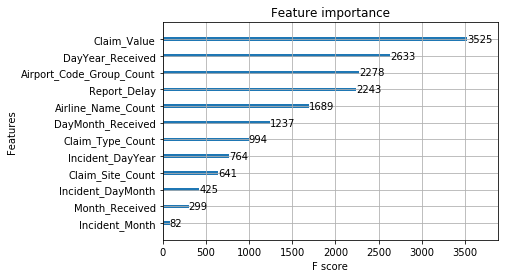

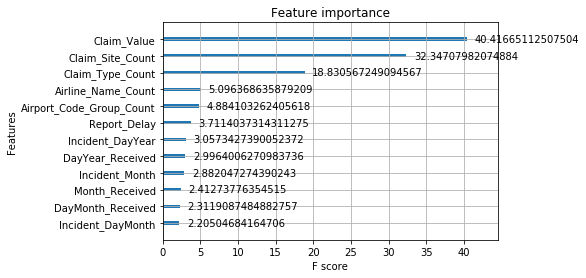

In [70]:
xgb.plot_importance(fit_model)

xgb.plot_importance(fit_model, importance_type="gain")
